<a href="https://colab.research.google.com/github/Dicere/WB_Internship/blob/main/0_7_Chek_new_feature.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install catboost

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.notebook import tqdm
from catboost import CatBoostClassifier, Pool
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score, classification_report, recall_score, precision_recall_curve,precision_score, precision_recall_fscore_support
import statsmodels.api as sm
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('/content/drive/MyDrive/WB_стажировка/wb_school_task_2.csv.gzip',compression='gzip')
df = df.drop_duplicates(ignore_index=True)

In [4]:
kvad_sum=(lambda x: sum(i**2 for i in x))
kvad_sum.__name__ = 'kvad_sum'

interkvartil_razmah = (lambda x: np.percentile(x, 75) - np.percentile(x, 25))
interkvartil_razmah.__name__ = 'interkvartil_razmah'

range_dannih = (lambda x: x.max()-x.min())
range_dannih.__name__ = 'range_dannih'

quant90 = lambda x: x.quantile(0.9)
quant90.__name__ = 'quant90'

In [5]:
aggs_list = ['min','max', 'mean', 'median', 'count', 'sum',kvad_sum,interkvartil_razmah,range_dannih,quant90]

In [6]:
df_agg = df[['id3','f1','f2','f3','f4','f5','f6','f7','f8']].groupby(by=['id3']).agg(aggs_list).reset_index()
df_agg.columns = ['_by_id3_'.join(col) for col in df_agg.columns.values]
df_agg = df_agg.rename(columns={'id3_by_id3_':'id3'})

In [7]:
df1 = pd.merge(df,df_agg,how='left',on=['id3'])

In [8]:
clear_df = df1[['f1','f2','f3','f4','f5','f6','f7','f8','f1_by_id3_sum', 'f2_by_id3_sum', 'f3_by_id3_sum', 'f4_by_id3_sum',
       'f5_by_id3_sum', 'f6_by_id3_sum', 'f7_by_id3_sum', 'f8_by_id3_sum']]

In [9]:
feature_dict = {}
def summ(b=0,i=0):
  name = str('sum_'+clear_df.columns[b] +"_"+ clear_df.columns[i])
  feature_dict[name] = clear_df.iloc[:,b] + clear_df.iloc[:,i]
def subtraction(b=0,i=0):
    name = str('subtraction_'+clear_df.columns[b] +"_"+ clear_df.columns[i])
    feature_dict[name] = abs(clear_df.iloc[:,b] - clear_df.iloc[:,i])
def multiplication(b=0,i=0):
    name = str('multiplication_'+clear_df.columns[b] +"_"+ clear_df.columns[i])
    feature_dict[name] = abs(clear_df.iloc[:,b] * clear_df.iloc[:,i])
def division(b=0,i=0):
    name = str('division_'+clear_df.columns[b] +"_"+ clear_df.columns[i])
    feature_dict[name] = abs((clear_df.iloc[:,b] / clear_df.iloc[:,i]).fillna(0))
    name = str('division_'+clear_df.columns[i]+"_"+clear_df.columns[b])
    feature_dict[name] = abs((clear_df.iloc[:,i] /clear_df.iloc[:,b]).fillna(0))

In [10]:
conversions_list = {'sum':summ,'subtraction':subtraction,'division':division,'multiplication':multiplication}

In [11]:
idx=0
for conv in conversions_list.keys():
  for b in range(len(clear_df.columns)-1):
    if conv == 'multiplication':
      for i in range(b,len(clear_df.columns)):
        conversions_list[conv](b,i)
    else:
      for i in range(b+1,len(clear_df.columns)):
        conversions_list[conv](b,i)


In [ ]:
df1 = df1.assign(**feature_dict)

In [13]:
cols_to_drop = df1.columns[df1.nunique() == 1]
df1 = df1.drop(cols_to_drop, axis=1)
df1.replace([np.inf, -np.inf], 0, inplace=True)

In [14]:
X = df1[df1.drop('label', axis=1).columns[4::]]
y=df1.label

In [15]:
N_SPLITS = 7
current_feat = list(X.columns[:8])

In [16]:
def test_features(columns,N_SPLITS):
  cv = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=22)
  cv_scores_AUC_ROC = np.empty(N_SPLITS)
  cv_scores_f1_score = np.empty(N_SPLITS)
  cv_scores_Precision = np.empty(N_SPLITS)
  cv_scores_Recall = np.empty(N_SPLITS)
  cv_scores = np.empty(N_SPLITS)
  roc_auc_score_1 = np.empty(N_SPLITS)
  for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
    # print('--'*10+f'TRIAL {trial.number} ~ '+f'FOLD {idx}'+'--'*10)
    X_train, X_val = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_val  = y.iloc[train_idx], y.iloc[test_idx]
    train_pool = Pool(X_train[columns], y_train, feature_names=columns)
    test_pool = Pool(X_val[columns], y_val, feature_names=columns)


    model = CatBoostClassifier()
    model.fit(
        train_pool,
        eval_set=test_pool,
        early_stopping_rounds=100,
        use_best_model=True,
        verbose=0

    )
    y_pred_metki = model.predict(test_pool)
    y_pred = model.predict_proba(test_pool)[:, 1]
    precision = precision_score(y_val, y_pred_metki)
    recall = recall_score(y_val, y_pred_metki)
    cv_scores_AUC_ROC[idx] = roc_auc_score(y_val, y_pred)
    cv_scores_f1_score[idx] = f1_score(y_val, y_pred_metki,average='macro')
    # print(precision)
    cv_scores_Precision[idx] = precision
    cv_scores_Recall[idx] = recall
  return np.mean(cv_scores_AUC_ROC),np.mean(cv_scores_f1_score),np.mean(cv_scores_Precision),np.mean(cv_scores_Recall)
  print("AUC_ROC----"+str(np.mean(cv_scores_AUC_ROC)))
  print("F1-score-----"+str(np.mean(cv_scores_f1_score)))
  print("Precision-----"+str(np.mean(cv_scores_Precision)))
  print("Recall-----"+str(np.mean(cv_scores_Recall)))

### Стартовые фичи

In [17]:
test_features(current_feat,N_SPLITS)

(0.7497612183590228,
 0.6521688420618404,
 0.7418994446413801,
 0.30912025827280065)

### +1 фича

In [18]:
columns= ['f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f2_by_id3_mean']

In [19]:
test_features(columns,N_SPLITS)

(0.758623261816581,
 0.6540957491218313,
 0.7333994720280212,
 0.31394217834895805)

### +2 фича

In [20]:
columns = ['f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'division_f1_f2', 'division_f7_f3_by_id3_sum']

In [21]:
test_features(columns,N_SPLITS)

(0.7613993723510063, 0.651405421439226, 0.7161741471425598, 0.3139525258169326)

### +3 фичи

In [22]:
columns = ['f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'sum_f3_f6', 'division_f2_f1', 'division_f7_f6_by_id3_sum']

In [23]:
test_features(columns,N_SPLITS)

(0.7567801289600739,
 0.6433384366493404,
 0.7096717637824368,
 0.3006456820016142)

### +4 фичи

In [24]:
columns = ['f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f1_by_id3_median', 'division_f2_f1', 'division_f4_f7', 'multiplication_f3_f6']

In [25]:
test_features(columns,N_SPLITS)

(0.7578215187836445,
 0.6553645135027372,
 0.7211610815901393,
 0.32124749073901615)

### +5 фичей


In [26]:
columns = ['f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f2_by_id3_median', 'sum_f3_f6', 'division_f2_f1', 'division_f7_f4', 'multiplication_f3_f3']

In [27]:
test_features(columns,N_SPLITS)

(0.7614077600596356,
 0.6420560387225727,
 0.7085253286576499,
 0.2994143333126384)

### +6 фичей

In [28]:
columns = ['f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f2_by_id3_mean', 'sum_f3_f6', 'division_f2_f1', 'division_f7_f4', 'division_f6_by_id3_sum_f7', 'multiplication_f3_f6']

In [29]:
test_features(columns,N_SPLITS)

(0.7651875528374631,
 0.6527306859302981,
 0.7017891545722093,
 0.3224374495560936)

### +9 фичей

In [30]:
columns = ['f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f1_by_id3_median', 'f6_by_id3_interkvartil_razmah', 'f7_by_id3_mean', 'sum_f3_f6', 'division_f1_f2', 'division_f4_f7', 'division_f7_f5', 'division_f7_f8', 'multiplication_f3_f3']

In [31]:
test_features(columns,N_SPLITS)

(0.7660353998850072,
 0.6700725365247342,
 0.7250010182598627,
 0.34792326317750044)

### 32 feature

In [32]:
columns = ['f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f1_by_id3_median', 'f2_by_id3_mean', 'f2_by_id3_median', 'f6_by_id3_min', 'f6_by_id3_median', 'f6_by_id3_interkvartil_razmah', 'sum_f3_f6', 'subtraction_f3_f6', 'subtraction_f3_by_id3_sum_f6_by_id3_sum', 'division_f2_f1', 'division_f2_f7', 'division_f3_f4', 'division_f4_f7', 'division_f7_f4', 'division_f8_f4', 'division_f7_f5', 'division_f7_f8', 'division_f2_by_id3_sum_f3_by_id3_sum', 'division_f2_by_id3_sum_f6_by_id3_sum', 'division_f2_by_id3_sum_f7_by_id3_sum', 'division_f7_by_id3_sum_f3_by_id3_sum', 'multiplication_f3_f3', 'multiplication_f3_f6', 'multiplication_f4_f7']

In [33]:
test_features(columns,N_SPLITS)

(0.7688250026308988, 0.663151346621588, 0.7226529021308832, 0.3369756420603878)

### 52 feature

In [34]:
columns =  ['f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f1_by_id3_median', 'f1_by_id3_interkvartil_razmah', 'f2_by_id3_mean', 'f2_by_id3_quant90', 'f3_by_id3_min', 'f3_by_id3_max', 'f6_by_id3_min', 'f6_by_id3_max', 'f6_by_id3_mean', 'f6_by_id3_median', 'f6_by_id3_interkvartil_razmah', 'f6_by_id3_range_dannih', 'f6_by_id3_quant90', 'f7_by_id3_mean', 'sum_f3_f6', 'sum_f4_f6', 'subtraction_f1_f7', 'subtraction_f2_f6', 'subtraction_f3_f6', 'subtraction_f4_f5', 'subtraction_f3_by_id3_sum_f6_by_id3_sum', 'division_f1_f2', 'division_f6_f3', 'division_f5_f4', 'division_f4_f7', 'division_f7_f4', 'division_f8_f4', 'division_f4_f4_by_id3_sum', 'division_f4_by_id3_sum_f4', 'division_f7_f5', 'division_f5_f2_by_id3_sum', 'division_f7_f8', 'division_f7_f3_by_id3_sum', 'division_f6_by_id3_sum_f7', 'division_f2_by_id3_sum_f3_by_id3_sum', 'division_f3_by_id3_sum_f2_by_id3_sum', 'division_f5_by_id3_sum_f2_by_id3_sum', 'division_f2_by_id3_sum_f6_by_id3_sum', 'division_f6_by_id3_sum_f2_by_id3_sum', 'division_f2_by_id3_sum_f7_by_id3_sum', 'division_f7_by_id3_sum_f3_by_id3_sum', 'multiplication_f3_f3', 'multiplication_f3_f6', 'multiplication_f6_f6']

In [35]:
test_features(columns,N_SPLITS)

(0.7701107862774038,
 0.6627505781507379,
 0.7413340021318253,
 0.3309223732952547)

In [36]:
feature = {'0': list(X.columns[:8]),
           '+1':['f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f2_by_id3_mean'],
           '+2': ['f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'division_f1_f2', 'division_f7_f3_by_id3_sum'],
           '+3': ['f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'sum_f3_f6', 'division_f2_f1', 'division_f7_f6_by_id3_sum'],
           '+4': ['f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f1_by_id3_median', 'division_f2_f1', 'division_f4_f7', 'multiplication_f3_f6'],
           '+5': ['f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f2_by_id3_median', 'sum_f3_f6', 'division_f2_f1', 'division_f7_f4', 'multiplication_f3_f3'],
           '+6': ['f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f2_by_id3_mean', 'sum_f3_f6', 'division_f2_f1', 'division_f7_f4', 'division_f6_by_id3_sum_f7', 'multiplication_f3_f6'],
           '+7': ['f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'subtraction_f3_by_id3_sum_f6_by_id3_sum', 'division_f2_f1', 'division_f7_f4', 'division_f7_f5', 'division_f3_by_id3_sum_f2_by_id3_sum', 'multiplication_f3_f3', 'multiplication_f3_f6'],
           '+8': ['f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f2_by_id3_mean', 'f6_by_id3_median', 'f7_by_id3_mean', 'sum_f3_f6', 'division_f2_f1', 'division_f7_f4', 'division_f7_f3_by_id3_sum', 'multiplication_f3_f6'],
           '+9': ['f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f1_by_id3_median', 'f6_by_id3_interkvartil_razmah', 'f7_by_id3_mean', 'sum_f3_f6', 'division_f1_f2', 'division_f4_f7', 'division_f7_f5', 'division_f7_f8', 'multiplication_f3_f3'],
           '+10': ['f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f2_by_id3_mean', 'sum_f3_f6', 'subtraction_f3_by_id3_sum_f6_by_id3_sum', 'division_f1_f2', 'division_f4_f7', 'division_f7_f5', 'division_f7_f8', 'division_f2_by_id3_sum_f3_by_id3_sum', 'multiplication_f3_f3', 'multiplication_f3_f6'],
           '+11': ['f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f2_by_id3_mean', 'f7_by_id3_mean', 'sum_f3_f6', 'division_f2_f1', 'division_f4_f7', 'division_f7_f4', 'division_f7_f5', 'division_f7_f8', 'division_f6_by_id3_sum_f7', 'multiplication_f3_f3', 'multiplication_f3_f6'],
           '+12': ['f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f2_by_id3_median', 'f6_by_id3_median', 'sum_f3_f6', 'division_f1_f2', 'division_f4_f7', 'division_f7_f4', 'division_f7_f5', 'division_f7_f8', 'division_f7_f3_by_id3_sum', 'division_f6_by_id3_sum_f2_by_id3_sum', 'multiplication_f3_f6', 'multiplication_f4_f7'],
           '+13': ['f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f2_by_id3_mean', 'f6_by_id3_mean', 'f6_by_id3_interkvartil_razmah', 'sum_f3_f6', 'subtraction_f3_f6', 'division_f2_f1', 'division_f4_f7', 'division_f7_f4', 'division_f7_f8', 'division_f7_f6_by_id3_sum', 'multiplication_f3_f3', 'multiplication_f3_f6', 'multiplication_f6_f6'],
           '+14': ['f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f2_by_id3_mean', 'f6_by_id3_mean', 'sum_f3_f6', 'subtraction_f3_f6', 'subtraction_f3_by_id3_sum_f6_by_id3_sum', 'division_f1_f2', 'division_f4_f7', 'division_f7_f4', 'division_f7_f5', 'division_f7_f8', 'division_f7_f6_by_id3_sum', 'division_f7_by_id3_sum_f6_by_id3_sum', 'multiplication_f3_f3', 'multiplication_f3_f6'],
           '+15': ['f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f1_by_id3_median', 'f2_by_id3_mean', 'f6_by_id3_mean', 'f6_by_id3_median', 'f7_by_id3_mean', 'sum_f3_f6', 'subtraction_f3_f6', 'division_f2_f1', 'division_f4_f7', 'division_f4_f4_by_id3_sum', 'division_f7_f5', 'division_f7_f8', 'multiplication_f3_f3', 'multiplication_f3_f6', 'multiplication_f4_f7'],
           '+16': ['f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f2_by_id3_median', 'f6_by_id3_interkvartil_razmah', 'sum_f3_f6', 'subtraction_f3_f6', 'subtraction_f3_by_id3_sum_f6_by_id3_sum', 'division_f1_f2', 'division_f4_f7', 'division_f7_f5', 'division_f7_f8', 'division_f7_f3_by_id3_sum', 'division_f3_by_id3_sum_f2_by_id3_sum', 'division_f7_by_id3_sum_f6_by_id3_sum', 'multiplication_f3_f3', 'multiplication_f3_f6', 'multiplication_f4_f7', 'multiplication_f6_f6'],
           '+17': ['f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f2_by_id3_mean', 'f2_by_id3_median', 'f6_by_id3_mean', 'f6_by_id3_interkvartil_razmah', 'f7_by_id3_mean', 'sum_f3_f6', 'subtraction_f3_f6', 'division_f2_f1', 'division_f4_f7', 'division_f7_f4', 'division_f7_f5', 'division_f7_f8', 'division_f6_by_id3_sum_f7', 'division_f3_by_id3_sum_f2_by_id3_sum', 'multiplication_f3_f3', 'multiplication_f3_f6', 'multiplication_f4_f7'],
           '+18': ['f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f1_by_id3_median', 'f2_by_id3_mean', 'f6_by_id3_mean', 'f6_by_id3_median', 'sum_f3_f6', 'subtraction_f3_f6', 'subtraction_f3_by_id3_sum_f6_by_id3_sum', 'division_f1_f2', 'division_f7_f4', 'division_f7_f5', 'division_f7_f8', 'division_f6_by_id3_sum_f7', 'division_f2_by_id3_sum_f3_by_id3_sum', 'division_f7_by_id3_sum_f3_by_id3_sum', 'multiplication_f3_f3', 'multiplication_f3_f4', 'multiplication_f3_f6', 'multiplication_f6_f6'],
           '+19': ['f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f6_by_id3_mean', 'f6_by_id3_median', 'sum_f3_f6', 'subtraction_f3_f6', 'subtraction_f3_by_id3_sum_f6_by_id3_sum', 'division_f1_f2', 'division_f4_f7', 'division_f7_f4', 'division_f4_f4_by_id3_sum', 'division_f7_f5', 'division_f7_f8', 'division_f3_by_id3_sum_f1_by_id3_sum', 'division_f3_by_id3_sum_f2_by_id3_sum', 'division_f6_by_id3_sum_f2_by_id3_sum', 'division_f7_by_id3_sum_f6_by_id3_sum', 'multiplication_f3_f3', 'multiplication_f3_f6', 'multiplication_f4_f7', 'multiplication_f6_f6'],
           '+20': ['f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f2_by_id3_mean', 'f2_by_id3_median', 'f6_by_id3_mean', 'f6_by_id3_median', 'sum_f3_f6', 'subtraction_f3_f6', 'subtraction_f3_by_id3_sum_f6_by_id3_sum', 'division_f1_f2', 'division_f2_f7', 'division_f4_f5', 'division_f4_f7', 'division_f7_f4', 'division_f7_f5', 'division_f7_f8', 'division_f6_by_id3_sum_f7', 'division_f6_by_id3_sum_f2_by_id3_sum', 'division_f7_by_id3_sum_f3_by_id3_sum', 'multiplication_f3_f3', 'multiplication_f3_f4', 'multiplication_f3_f6'],
           '+21': ['f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f2_by_id3_mean', 'f6_by_id3_mean', 'f6_by_id3_median', 'f6_by_id3_interkvartil_razmah', 'sum_f3_f6', 'subtraction_f3_f6', 'subtraction_f3_by_id3_sum_f6_by_id3_sum', 'division_f1_f2', 'division_f4_f7', 'division_f7_f4', 'division_f5_by_id3_sum_f4', 'division_f7_f5', 'division_f7_f8', 'division_f3_by_id3_sum_f2_by_id3_sum', 'division_f2_by_id3_sum_f6_by_id3_sum', 'division_f6_by_id3_sum_f2_by_id3_sum', 'division_f7_by_id3_sum_f3_by_id3_sum', 'multiplication_f3_f3', 'multiplication_f3_f6', 'multiplication_f4_f7', 'multiplication_f6_f6'],
           '+22': ['f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f2_by_id3_mean', 'f2_by_id3_median', 'f6_by_id3_median', 'f6_by_id3_interkvartil_razmah', 'f7_by_id3_mean', 'sum_f3_f6', 'subtraction_f3_f6', 'subtraction_f3_by_id3_sum_f6_by_id3_sum', 'division_f1_f2', 'division_f4_f7', 'division_f7_f4', 'division_f4_f4_by_id3_sum', 'division_f7_f5', 'division_f7_f8', 'division_f1_by_id3_sum_f3_by_id3_sum', 'division_f3_by_id3_sum_f2_by_id3_sum', 'division_f2_by_id3_sum_f6_by_id3_sum', 'multiplication_f3_f3', 'multiplication_f3_f4', 'multiplication_f3_f6', 'multiplication_f3_f7', 'multiplication_f6_f6'],
           '+23': ['f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f1_by_id3_median', 'f2_by_id3_mean', 'f3_by_id3_min', 'f6_by_id3_mean', 'f6_by_id3_interkvartil_razmah', 'f6_by_id3_quant90', 'f7_by_id3_mean', 'sum_f3_f6', 'subtraction_f3_f6', 'division_f2_f1', 'division_f4_f3', 'division_f4_f7', 'division_f7_f4', 'division_f5_by_id3_sum_f4', 'division_f7_f5', 'division_f7_f8', 'division_f7_f3_by_id3_sum', 'division_f7_f6_by_id3_sum', 'division_f3_by_id3_sum_f2_by_id3_sum', 'multiplication_f3_f3', 'multiplication_f3_f6', 'multiplication_f4_f7', 'multiplication_f6_f6'],
           '+24': ['f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f1_by_id3_median', 'f2_by_id3_mean', 'f2_by_id3_median', 'f4_by_id3_median', 'f6_by_id3_min', 'f6_by_id3_median', 'f6_by_id3_interkvartil_razmah', 'sum_f3_f6', 'subtraction_f3_f6', 'division_f2_f1', 'division_f4_f7', 'division_f7_f4', 'division_f7_f5', 'division_f7_f8', 'division_f7_f3_by_id3_sum', 'division_f2_by_id3_sum_f3_by_id3_sum', 'division_f3_by_id3_sum_f2_by_id3_sum', 'division_f6_by_id3_sum_f2_by_id3_sum', 'division_f7_by_id3_sum_f3_by_id3_sum', 'multiplication_f3_f3', 'multiplication_f3_f4', 'multiplication_f3_f6', 'multiplication_f3_f7', 'multiplication_f6_f6'],
           '+25': ['f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f1_by_id3_median', 'f2_by_id3_mean', 'f6_by_id3_mean', 'f6_by_id3_median', 'f6_by_id3_range_dannih', 'f6_by_id3_quant90', 'sum_f3_f6', 'subtraction_f1_f6', 'subtraction_f3_f6', 'subtraction_f3_by_id3_sum_f6_by_id3_sum', 'division_f2_f1', 'division_f2_f7', 'division_f4_f7', 'division_f8_f4', 'division_f7_f5', 'division_f7_f8', 'division_f7_f6_by_id3_sum', 'division_f2_by_id3_sum_f3_by_id3_sum', 'division_f3_by_id3_sum_f2_by_id3_sum', 'division_f7_by_id3_sum_f3_by_id3_sum', 'multiplication_f3_f3', 'multiplication_f3_f4', 'multiplication_f3_f6', 'multiplication_f4_f7', 'multiplication_f6_f6'],
           '+26': ['f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f1_by_id3_median', 'f2_by_id3_median', 'f6_by_id3_mean', 'f6_by_id3_interkvartil_razmah', 'f6_by_id3_quant90', 'f7_by_id3_mean', 'sum_f3_f6', 'subtraction_f1_f6', 'subtraction_f3_f6', 'subtraction_f3_by_id3_sum_f6_by_id3_sum', 'division_f2_f1', 'division_f4_f7', 'division_f7_f4', 'division_f7_f5', 'division_f5_f2_by_id3_sum', 'division_f7_f8', 'division_f7_f3_by_id3_sum', 'division_f3_by_id3_sum_f2_by_id3_sum', 'division_f5_by_id3_sum_f2_by_id3_sum', 'division_f2_by_id3_sum_f6_by_id3_sum', 'division_f6_by_id3_sum_f2_by_id3_sum', 'division_f7_by_id3_sum_f6_by_id3_sum', 'multiplication_f3_f3', 'multiplication_f3_f6', 'multiplication_f4_f7', 'multiplication_f6_f6'],
           '+27': ['f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f2_by_id3_mean', 'f2_by_id3_median', 'f2_by_id3_quant90', 'f4_by_id3_min', 'f6_by_id3_min', 'f6_by_id3_median', 'f6_by_id3_quant90', 'f7_by_id3_mean', 'sum_f3_f6', 'subtraction_f3_f6', 'subtraction_f3_by_id3_sum_f6_by_id3_sum', 'division_f2_f1', 'division_f4_f5', 'division_f4_f7', 'division_f7_f4', 'division_f7_f5', 'division_f7_f8', 'division_f6_by_id3_sum_f7', 'division_f2_by_id3_sum_f3_by_id3_sum', 'division_f2_by_id3_sum_f6_by_id3_sum', 'division_f6_by_id3_sum_f2_by_id3_sum', 'division_f7_by_id3_sum_f6_by_id3_sum', 'multiplication_f3_f3', 'multiplication_f3_f6', 'multiplication_f3_f7', 'multiplication_f4_f7', 'multiplication_f6_f6'],
           '+28': ['f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f2_by_id3_mean', 'f2_by_id3_median', 'f2_by_id3_quant90', 'f6_by_id3_mean', 'f6_by_id3_median', 'f6_by_id3_quant90', 'sum_f3_f6', 'subtraction_f3_f6', 'subtraction_f3_by_id3_sum_f6_by_id3_sum', 'division_f2_f1', 'division_f4_f5', 'division_f6_f4', 'division_f4_f7', 'division_f7_f4', 'division_f4_f8', 'division_f4_by_id3_sum_f4', 'division_f7_f5', 'division_f7_f8', 'division_f7_f4_by_id3_sum', 'division_f7_f6_by_id3_sum', 'division_f2_by_id3_sum_f3_by_id3_sum', 'division_f3_by_id3_sum_f2_by_id3_sum', 'division_f2_by_id3_sum_f6_by_id3_sum', 'division_f7_by_id3_sum_f6_by_id3_sum', 'multiplication_f3_f3', 'multiplication_f3_f6', 'multiplication_f4_f7_by_id3_sum', 'multiplication_f6_f6'],
           '+29': ['f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f2_by_id3_mean', 'f2_by_id3_median', 'f6_by_id3_min', 'f6_by_id3_mean', 'f6_by_id3_median', 'f6_by_id3_interkvartil_razmah', 'f6_by_id3_quant90', 'f7_by_id3_mean', 'sum_f3_f6', 'subtraction_f2_f6', 'subtraction_f3_f6', 'subtraction_f3_f7_by_id3_sum', 'subtraction_f3_by_id3_sum_f6_by_id3_sum', 'division_f2_f1', 'division_f2_f7', 'division_f4_f7', 'division_f7_f4', 'division_f4_f4_by_id3_sum', 'division_f7_f5', 'division_f7_f8', 'division_f7_f6_by_id3_sum', 'division_f2_by_id3_sum_f3_by_id3_sum', 'division_f7_by_id3_sum_f2_by_id3_sum', 'division_f7_by_id3_sum_f3_by_id3_sum', 'multiplication_f3_f3', 'multiplication_f3_f4', 'multiplication_f3_f6', 'multiplication_f4_f7', 'multiplication_f6_f6'],
           '+30': ['f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f1_by_id3_median', 'f1_by_id3_quant90', 'f2_by_id3_mean', 'f2_by_id3_median', 'f2_by_id3_quant90', 'f4_by_id3_median', 'f6_by_id3_min', 'f6_by_id3_mean', 'sum_f4_f1_by_id3_sum', 'subtraction_f1_f6', 'subtraction_f1_f7', 'subtraction_f3_f6', 'division_f2_f1', 'division_f4_f7', 'division_f7_f4', 'division_f4_by_id3_sum_f4', 'division_f5_by_id3_sum_f4', 'division_f7_f5', 'division_f7_f8', 'division_f7_f3_by_id3_sum', 'division_f1_by_id3_sum_f3_by_id3_sum', 'division_f6_by_id3_sum_f1_by_id3_sum', 'division_f2_by_id3_sum_f3_by_id3_sum', 'division_f3_by_id3_sum_f2_by_id3_sum', 'division_f2_by_id3_sum_f6_by_id3_sum', 'division_f7_by_id3_sum_f8_by_id3_sum', 'multiplication_f3_f3', 'multiplication_f3_f4', 'multiplication_f3_f6', 'multiplication_f6_f6'],
           '+31': ['f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f1_by_id3_median', 'f2_by_id3_mean', 'f2_by_id3_median', 'f6_by_id3_mean', 'f6_by_id3_median', 'f6_by_id3_range_dannih', 'f7_by_id3_mean', 'sum_f3_f6', 'subtraction_f1_f6', 'subtraction_f3_f6', 'subtraction_f3_by_id3_sum_f6_by_id3_sum', 'division_f2_f1', 'division_f4_f7', 'division_f7_f4', 'division_f4_f8', 'division_f4_by_id3_sum_f4', 'division_f7_f5', 'division_f5_f2_by_id3_sum', 'division_f7_f8', 'division_f7_f3_by_id3_sum', 'division_f7_f6_by_id3_sum', 'division_f1_by_id3_sum_f3_by_id3_sum', 'division_f2_by_id3_sum_f3_by_id3_sum', 'division_f3_by_id3_sum_f2_by_id3_sum', 'division_f6_by_id3_sum_f2_by_id3_sum', 'division_f7_by_id3_sum_f3_by_id3_sum', 'division_f5_by_id3_sum_f8_by_id3_sum', 'multiplication_f3_f3', 'multiplication_f3_f6', 'multiplication_f4_f7', 'multiplication_f6_f6'],
           '+32': ['f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f2_by_id3_mean', 'f2_by_id3_median', 'f2_by_id3_quant90', 'f3_by_id3_min', 'f6_by_id3_mean', 'f6_by_id3_median', 'f6_by_id3_quant90', 'sum_f3_f6', 'subtraction_f1_f6', 'subtraction_f3_f6', 'subtraction_f3_by_id3_sum_f6_by_id3_sum', 'division_f2_f1', 'division_f7_f2', 'division_f4_f5', 'division_f4_f7', 'division_f7_f4', 'division_f4_f8', 'division_f4_f4_by_id3_sum', 'division_f7_f5', 'division_f7_f8', 'division_f7_f3_by_id3_sum', 'division_f6_by_id3_sum_f7', 'division_f2_by_id3_sum_f3_by_id3_sum', 'division_f3_by_id3_sum_f2_by_id3_sum', 'division_f5_by_id3_sum_f2_by_id3_sum', 'division_f6_by_id3_sum_f2_by_id3_sum', 'division_f7_by_id3_sum_f6_by_id3_sum', 'multiplication_f3_f3', 'multiplication_f3_f6', 'multiplication_f4_f7', 'multiplication_f6_f6', 'multiplication_f6_f7'],
           '+33': ['f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f1_by_id3_median', 'f1_by_id3_interkvartil_razmah', 'f2_by_id3_quant90', 'f4_by_id3_min', 'f6_by_id3_min', 'f6_by_id3_mean', 'f6_by_id3_median', 'f6_by_id3_interkvartil_razmah', 'f6_by_id3_quant90', 'f7_by_id3_kvad_sum', 'sum_f3_f6', 'sum_f4_f1_by_id3_sum', 'subtraction_f1_f6', 'subtraction_f3_f6', 'subtraction_f3_by_id3_sum_f6_by_id3_sum', 'division_f2_f1', 'division_f4_f5', 'division_f4_f7', 'division_f7_f4', 'division_f4_f8', 'division_f7_f5', 'division_f7_f8', 'division_f7_f3_by_id3_sum', 'division_f7_f6_by_id3_sum', 'division_f6_by_id3_sum_f7', 'division_f2_by_id3_sum_f6_by_id3_sum', 'division_f6_by_id3_sum_f2_by_id3_sum', 'division_f7_by_id3_sum_f3_by_id3_sum', 'division_f7_by_id3_sum_f6_by_id3_sum', 'multiplication_f3_f3', 'multiplication_f3_f6', 'multiplication_f3_f7', 'multiplication_f6_f6'],
           '+34': ['f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f1_by_id3_min', 'f1_by_id3_median', 'f2_by_id3_mean', 'f2_by_id3_median', 'f6_by_id3_min', 'f6_by_id3_max', 'f6_by_id3_median', 'f6_by_id3_interkvartil_razmah', 'f7_by_id3_mean', 'sum_f3_f6', 'subtraction_f2_f6', 'subtraction_f3_f6', 'subtraction_f3_by_id3_sum_f6_by_id3_sum', 'division_f1_f2', 'division_f2_f7', 'division_f4_f5', 'division_f4_f7', 'division_f4_f8', 'division_f5_f7', 'division_f7_f5', 'division_f7_f8', 'division_f6_by_id3_sum_f7', 'division_f1_by_id3_sum_f3_by_id3_sum', 'division_f6_by_id3_sum_f1_by_id3_sum', 'division_f3_by_id3_sum_f2_by_id3_sum', 'division_f5_by_id3_sum_f2_by_id3_sum', 'division_f6_by_id3_sum_f2_by_id3_sum', 'division_f7_by_id3_sum_f3_by_id3_sum', 'multiplication_f3_f3', 'multiplication_f3_f6', 'multiplication_f3_f7', 'multiplication_f4_f5', 'multiplication_f4_f7', 'multiplication_f6_f6'],
           '+35':['f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f1_by_id3_mean', 'f1_by_id3_median', 'f2_by_id3_mean', 'f2_by_id3_median', 'f6_by_id3_min', 'f6_by_id3_median', 'f6_by_id3_interkvartil_razmah', 'f6_by_id3_range_dannih', 'f6_by_id3_quant90', 'sum_f3_f6', 'subtraction_f1_f6', 'subtraction_f1_f7', 'subtraction_f2_f6', 'subtraction_f3_f6', 'subtraction_f3_by_id3_sum_f6_by_id3_sum', 'division_f1_f2', 'division_f7_f2', 'division_f4_f7', 'division_f7_f4', 'division_f4_f8', 'division_f8_f4', 'division_f5_by_id3_sum_f4', 'division_f7_f5', 'division_f7_f8', 'division_f7_f3_by_id3_sum', 'division_f2_by_id3_sum_f3_by_id3_sum', 'division_f3_by_id3_sum_f2_by_id3_sum', 'division_f5_by_id3_sum_f2_by_id3_sum', 'division_f6_by_id3_sum_f2_by_id3_sum', 'division_f7_by_id3_sum_f3_by_id3_sum', 'multiplication_f3_f3', 'multiplication_f3_f6', 'multiplication_f4_f5', 'multiplication_f4_f7', 'multiplication_f6_f6'],
           '+36':['f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f1_by_id3_mean', 'f1_by_id3_median', 'f1_by_id3_interkvartil_razmah', 'f2_by_id3_mean', 'f2_by_id3_median', 'f2_by_id3_quant90', 'f6_by_id3_min', 'f6_by_id3_mean', 'f6_by_id3_median', 'f6_by_id3_interkvartil_razmah', 'f6_by_id3_quant90', 'f7_by_id3_mean', 'sum_f3_f6', 'subtraction_f1_f6', 'subtraction_f3_f6', 'subtraction_f3_f7_by_id3_sum', 'subtraction_f3_by_id3_sum_f6_by_id3_sum', 'division_f2_f1', 'division_f4_f7', 'division_f7_f4', 'division_f4_f8', 'division_f4_f5_by_id3_sum', 'division_f7_f5', 'division_f7_f8', 'division_f7_f3_by_id3_sum', 'division_f3_by_id3_sum_f7', 'division_f2_by_id3_sum_f3_by_id3_sum', 'division_f5_by_id3_sum_f2_by_id3_sum', 'division_f2_by_id3_sum_f6_by_id3_sum', 'division_f6_by_id3_sum_f2_by_id3_sum', 'multiplication_f3_f3', 'multiplication_f3_f6', 'multiplication_f3_f7', 'multiplication_f4_f7', 'multiplication_f4_f7_by_id3_sum', 'multiplication_f6_f6'],
           '+37':['f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f1_by_id3_median', 'f2_by_id3_mean', 'f2_by_id3_median', 'f4_by_id3_min', 'f4_by_id3_interkvartil_razmah', 'f6_by_id3_mean', 'f6_by_id3_median', 'f6_by_id3_interkvartil_razmah', 'f7_by_id3_min', 'f7_by_id3_mean', 'sum_f3_f6', 'sum_f6_f7', 'subtraction_f1_f6', 'subtraction_f3_f6', 'subtraction_f3_f7_by_id3_sum', 'subtraction_f3_by_id3_sum_f6_by_id3_sum', 'division_f2_f1', 'division_f2_f7', 'division_f7_f2', 'division_f4_f3', 'division_f4_f5', 'division_f6_f4', 'division_f4_f7', 'division_f7_f4', 'division_f8_f4', 'division_f4_by_id3_sum_f4', 'division_f7_f5', 'division_f7_f8', 'division_f7_f3_by_id3_sum', 'division_f2_by_id3_sum_f3_by_id3_sum', 'division_f3_by_id3_sum_f2_by_id3_sum', 'division_f2_by_id3_sum_f6_by_id3_sum', 'multiplication_f3_f3', 'multiplication_f3_f6', 'multiplication_f3_f7', 'multiplication_f4_f7', 'multiplication_f6_f6'],
           '+38':['f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f1_by_id3_mean', 'f1_by_id3_median', 'f1_by_id3_quant90', 'f2_by_id3_mean', 'f2_by_id3_median', 'f6_by_id3_min', 'f6_by_id3_max', 'f6_by_id3_mean', 'f6_by_id3_median', 'f6_by_id3_interkvartil_razmah', 'sum_f3_f6', 'subtraction_f3_f6', 'subtraction_f3_by_id3_sum_f6_by_id3_sum', 'division_f2_f1', 'division_f7_f2', 'division_f6_f4', 'division_f4_f7', 'division_f7_f4', 'division_f4_f8', 'division_f4_f4_by_id3_sum', 'division_f7_f5', 'division_f7_f8', 'division_f7_f3_by_id3_sum', 'division_f1_by_id3_sum_f3_by_id3_sum', 'division_f6_by_id3_sum_f1_by_id3_sum', 'division_f2_by_id3_sum_f3_by_id3_sum', 'division_f3_by_id3_sum_f2_by_id3_sum', 'division_f2_by_id3_sum_f6_by_id3_sum', 'division_f6_by_id3_sum_f2_by_id3_sum', 'division_f7_by_id3_sum_f3_by_id3_sum', 'division_f5_by_id3_sum_f8_by_id3_sum', 'division_f7_by_id3_sum_f6_by_id3_sum', 'multiplication_f3_f3', 'multiplication_f3_f4', 'multiplication_f3_f6', 'multiplication_f3_f7', 'multiplication_f4_f7', 'multiplication_f6_f6'],
           '+39':['f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f1_by_id3_mean', 'f2_by_id3_mean', 'f2_by_id3_median', 'f2_by_id3_kvad_sum', 'f6_by_id3_min', 'f6_by_id3_mean', 'f6_by_id3_median', 'f6_by_id3_interkvartil_razmah', 'f6_by_id3_range_dannih', 'f6_by_id3_quant90', 'f7_by_id3_min', 'sum_f3_f6', 'sum_f4_f2_by_id3_sum', 'subtraction_f1_f6', 'subtraction_f3_f6', 'subtraction_f3_by_id3_sum_f6_by_id3_sum', 'division_f2_f1', 'division_f2_f7', 'division_f4_f5', 'division_f6_f4', 'division_f4_f7', 'division_f7_f4', 'division_f2_by_id3_sum_f4', 'division_f5_by_id3_sum_f4', 'division_f5_f7', 'division_f7_f8', 'division_f7_f3_by_id3_sum', 'division_f3_by_id3_sum_f1_by_id3_sum', 'division_f6_by_id3_sum_f1_by_id3_sum', 'division_f2_by_id3_sum_f3_by_id3_sum', 'division_f6_by_id3_sum_f2_by_id3_sum', 'division_f3_by_id3_sum_f7_by_id3_sum', 'division_f8_by_id3_sum_f3_by_id3_sum', 'division_f6_by_id3_sum_f8_by_id3_sum', 'multiplication_f3_f3', 'multiplication_f3_f6', 'multiplication_f3_f7', 'multiplication_f4_f7', 'multiplication_f6_f6'],
           '+40':['f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f1_by_id3_median', 'f1_by_id3_quant90', 'f2_by_id3_mean', 'f2_by_id3_median', 'f6_by_id3_min', 'f6_by_id3_mean', 'f6_by_id3_median', 'f6_by_id3_interkvartil_razmah', 'f6_by_id3_quant90', 'f7_by_id3_min', 'sum_f2_f7_by_id3_sum', 'sum_f3_f6', 'subtraction_f2_f6', 'subtraction_f3_f6', 'subtraction_f3_by_id3_sum_f6_by_id3_sum', 'division_f2_f1', 'division_f2_f7', 'division_f6_f3', 'division_f6_f4', 'division_f4_f7', 'division_f7_f4', 'division_f4_f8', 'division_f8_f4', 'division_f7_f5', 'division_f7_f8', 'division_f2_by_id3_sum_f3_by_id3_sum', 'division_f3_by_id3_sum_f2_by_id3_sum', 'division_f5_by_id3_sum_f2_by_id3_sum', 'division_f2_by_id3_sum_f6_by_id3_sum', 'division_f6_by_id3_sum_f2_by_id3_sum', 'division_f7_by_id3_sum_f2_by_id3_sum', 'division_f3_by_id3_sum_f7_by_id3_sum', 'division_f7_by_id3_sum_f6_by_id3_sum', 'multiplication_f3_f3', 'multiplication_f3_f4', 'multiplication_f3_f6', 'multiplication_f3_f7', 'multiplication_f4_f7', 'multiplication_f5_f7_by_id3_sum', 'multiplication_f6_f6'],
          #  '+1':['f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f2_by_id3_mean'],
          #  '+1':['f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f2_by_id3_mean'],
          #  '+1':['f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f2_by_id3_mean'],

           }

In [37]:
scores_AUC_ROC=[]
scores_f1_score=[]
scores_Precision=[]
scores_Recall=[]
for i in feature.keys():
  auc,f1,pr,rc = test_features(feature[i],N_SPLITS)
  scores_AUC_ROC.append(auc)
  scores_f1_score.append(f1)
  scores_Precision.append(pr)
  scores_Recall.append(rc)
scores_dict = {'ROC_AUC':scores_AUC_ROC,
               'f1_score':scores_f1_score,
               'Precision':scores_Precision,
               'Recall':scores_Recall,}

In [38]:
def plot_info(scores,metrics):
  plt.figure(figsize=(20,5))
  plt.plot(scores,'-o',color='blue')
  # plt.scatter([iter],[best_f1], color='blue', s=300, alpha=1)
  plt.xlabel('Feature count',size=14)
  plt.ylabel(f'{metrics}',size=14)
  # plt.title(f'Best F1_Score = {best_f1:.3f} with {len(columns_on_with_best_score)} features',size=18)
  plt.show()

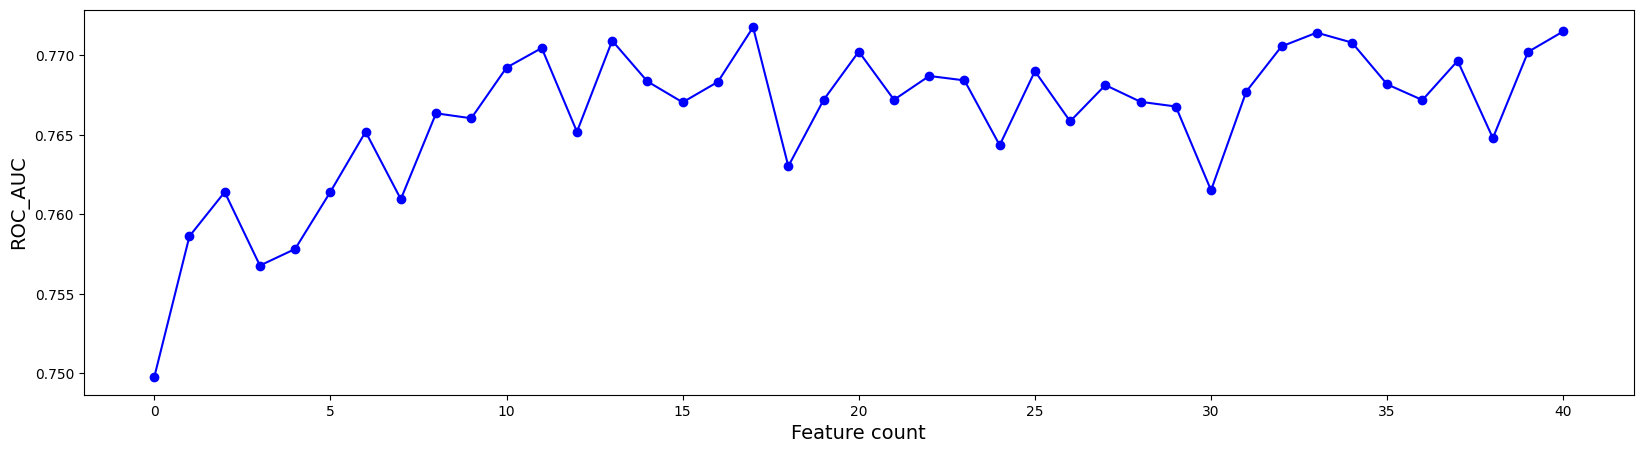

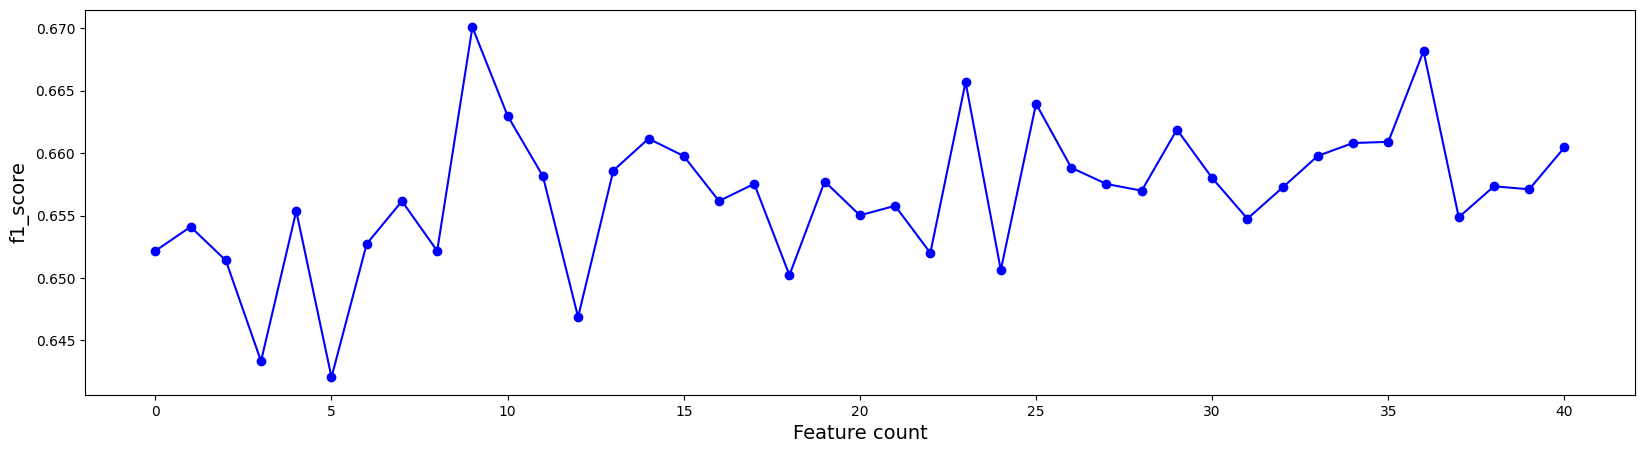

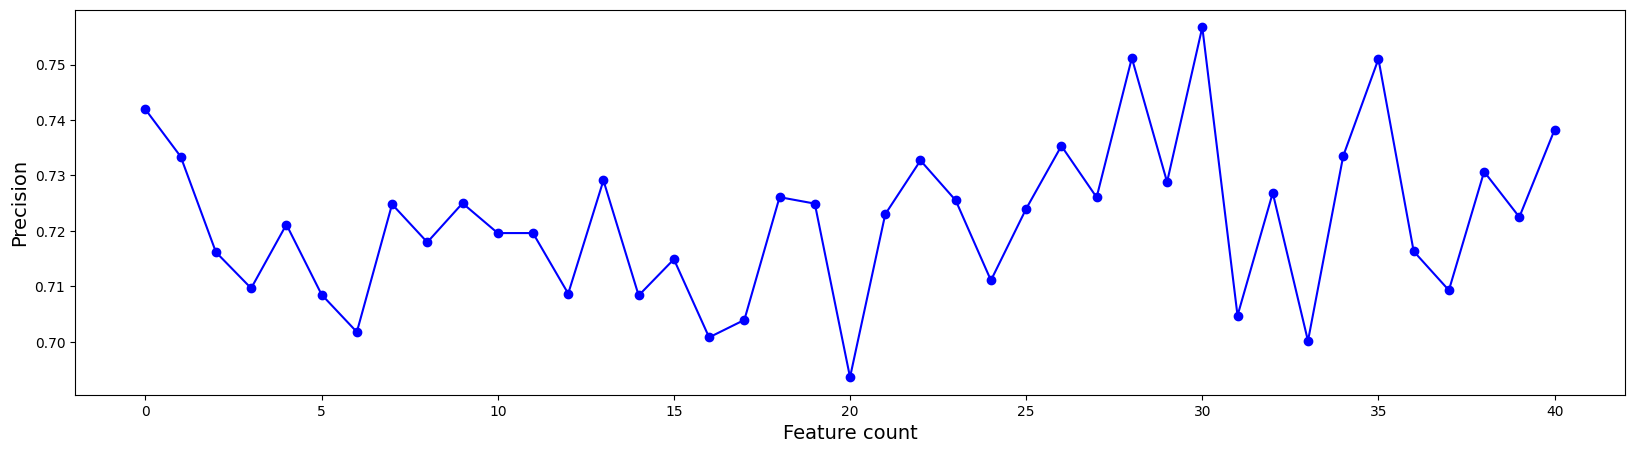

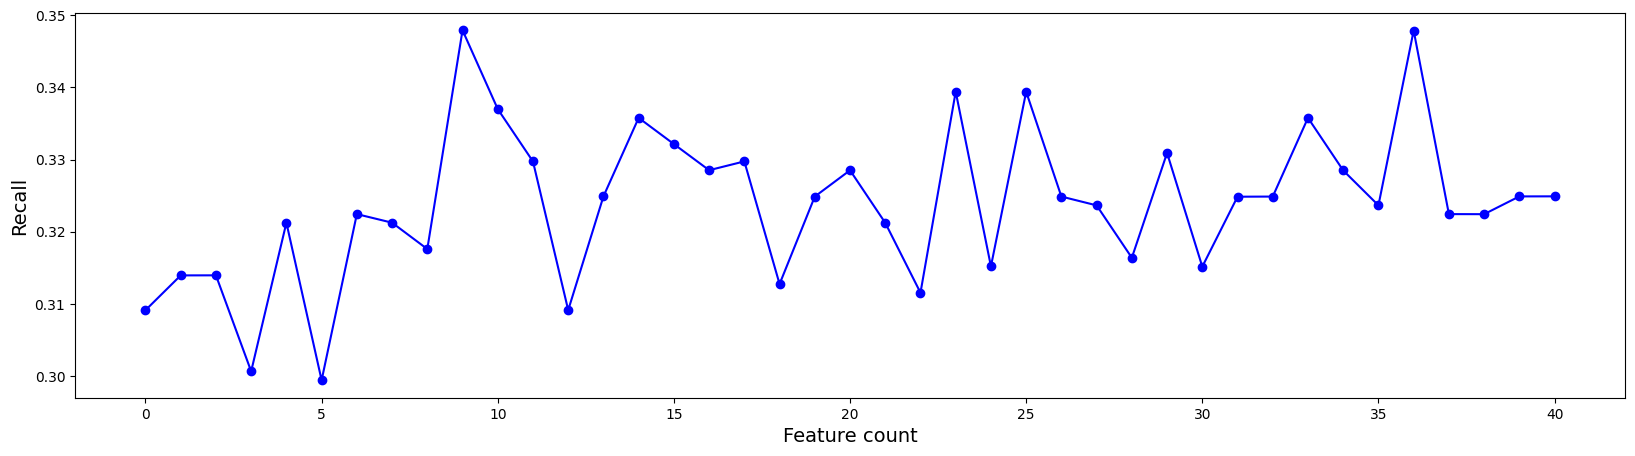

In [39]:
for i in scores_dict.keys():
  plot_info(scores_dict[i],i)